In [1]:
"""
Notebook for training the transformer model for the Lorenz system.
=====
Distributed by: Notre Dame SCAI Lab (MIT Liscense)
- Associated publication:
url: https://arxiv.org/abs/2010.03957
doi: 
github: https://github.com/zabaras/transformer-physx
=====
"""
!nvidia-smi

Mon Jul 19 03:16:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Environment Setup

Use pip to install from [PyPI](https://pypi.org/project/trphysx/).


In [2]:
!pip install trphysx

First mount google drive and clone transformer physx repo.

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
%cd /content/gdrive/MyDrive/
% mkdir -p transformer_physx/rossler
% cd transformer_physx/rossler

/content/gdrive/MyDrive
/content/gdrive/MyDrive/transformer_physx/rossler


## Downloading Data and Models

Now lets download the training and validation data for the lorenz system. Info on wget from [Google drive](https://stackoverflow.com/questions/37453841/download-a-file-from-google-drive-using-wget). This will eventually be update to zenodo repo.

In [5]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [6]:
!wget -O ./data/rossler_training.hdf5 "https://drive.google.com/uc?export=download&id=1eEXYbiZEz5rlEBoF3erDA_sqNWP0AFtp"
!wget -O ./data/rossler_valid.hdf5 "https://drive.google.com/uc?export=download&id=1LSCmkeM2Z6n8f5bzTkx50YuZvcL2WLsk"

--2021-07-19 03:16:03--  https://drive.google.com/uc?export=download&id=1eEXYbiZEz5rlEBoF3erDA_sqNWP0AFtp
Resolving drive.google.com (drive.google.com)... 74.125.195.138, 74.125.195.100, 74.125.195.139, ...
Connecting to drive.google.com (drive.google.com)|74.125.195.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-0o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/avttj6rhquous6hkfimrphbs4lbsc0lb/1626664500000/01559412990587423567/*/1eEXYbiZEz5rlEBoF3erDA_sqNWP0AFtp?e=download [following]
--2021-07-19 03:16:03--  https://doc-0k-0o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/avttj6rhquous6hkfimrphbs4lbsc0lb/1626664500000/01559412990587423567/*/1eEXYbiZEz5rlEBoF3erDA_sqNWP0AFtp?e=download
Resolving doc-0k-0o-docs.googleusercontent.com (doc-0k-0o-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to doc-0k-0o-docs.googleusercontent.com (doc-0k

Next lets download a pretrained embedding model. You can replace with with your own if you want.

In [7]:
!wget -O ./embedding_rossler300.pth "https://drive.google.com/uc?export=download&id=1V0MMh8dm5E8OiZTc8xMaiAjjcswdP1nL"

--2021-07-19 03:16:04--  https://drive.google.com/uc?export=download&id=1V0MMh8dm5E8OiZTc8xMaiAjjcswdP1nL
Resolving drive.google.com (drive.google.com)... 74.125.195.102, 74.125.195.101, 74.125.195.113, ...
Connecting to drive.google.com (drive.google.com)|74.125.195.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-0o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8o3gb32ck5hn06e4rtsm958udpjh76f9/1626664500000/01559412990587423567/*/1V0MMh8dm5E8OiZTc8xMaiAjjcswdP1nL?e=download [following]
--2021-07-19 03:16:05--  https://doc-00-0o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8o3gb32ck5hn06e4rtsm958udpjh76f9/1626664500000/01559412990587423567/*/1V0MMh8dm5E8OiZTc8xMaiAjjcswdP1nL?e=download
Resolving doc-00-0o-docs.googleusercontent.com (doc-00-0o-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to doc-00-0o-docs.googleusercontent.com (doc-00

# Transformer-PhysX Rossler System

The Rossler system is **not** a prebuilt example in trphysx thus we need to create four classes for our numerical example:
- *Config class* - Embedding and mainly transformer architecture parameters
- *Embedding class* - Convert states into embedding vector
- *Visualization class* - Visualize predictions
- *Transformer dataset class* - Create dataset for training

Fortunately trphysx has base classes for all of these that contain both useful methods and as well as abstract declarations to help guide you.

In [8]:
import sys
import os
import logging
import h5py
import torch
import torch.nn as nn
import numpy as np

from typing import Dict, List, Tuple
# Torch imports
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torch.optim.lr_scheduler import ExponentialLR
# Trphysx imports
from trphysx.config import HfArgumentParser
from trphysx.config.args import ModelArguments, TrainingArguments, DataArguments, ArgUtils
from trphysx.embedding import EmbeddingModel
from trphysx.config.configuration_phys import PhysConfig
from trphysx.data_utils.dataset_phys import PhysicalDataset
from trphysx.transformer import PhysformerTrain, PhysformerGPT2
from trphysx.utils.trainer import Trainer

Tensor = torch.Tensor
TensorTuple = Tuple[torch.Tensor]
FloatTuple = Tuple[float]

logger = logging.getLogger(__name__)

Set training arguments. For running this outside of a notebook, you would use "sys.argv" and then no arguement when you parse args into dataclasses. This would allow the use of command line parameters as well.

In [9]:
argv = []
argv = argv + ["--init_name", "rossler"]
argv = argv + ["--embedding_file_or_path", "./embedding_rossler300.pth"]
argv = argv + ["--training_h5_file","./data/rossler_training.hdf5"]
argv = argv + ["--eval_h5_file","./data/rossler_valid.hdf5"]
argv = argv + ["--train_batch_size", "32"]
argv = argv + ["--stride", "64"]
argv = argv + ["--n_train", "2048"]
argv = argv + ["--save_steps", "25"]
argv = argv + ["--n_eval", "16"]

## Rossler Config Class

In [10]:
class RosslerConfig(PhysConfig):
    """
    This is the configuration class for the modeling of the Rossler system.
    """

    model_type = "rossler"

    def __init__(
        self,
        n_ctx=64,
        n_embd=32,
        n_layer=4,
        n_head=4, # n_head must be a factor of n_embd
        state_dims=[3],
        activation_function="gelu_new",
        initializer_range=0.02,
        **kwargs
    ):
        super().__init__(
            n_ctx=n_ctx,
            n_embd=n_embd,
            n_layer=n_layer,
            n_head=n_head,
            state_dims=state_dims,
            activation_function=activation_function,
            initializer_range=initializer_range,
            **kwargs
        )

## Embedding Neural Network Class

Note here that we only need a subset of the methods needed for training the embedding model namely we just need "embed" and "recover" methods.

In [11]:
class RosslerEmbedding(EmbeddingModel):
    """Embedding model for the Rossler ODE system

    Args:
        config (PhysConfig) Configuration class with transformer/embedding parameters
    """
    model_name = "embedding_rossler"

    def __init__(self, config: PhysConfig) -> None:
        """Constructor method
        """
        super().__init__(config)

        hidden_states = int(abs(config.state_dims[0] - config.n_embd)/2) + 1
        hidden_states = 500

        self.observableNet = nn.Sequential(
            nn.Linear(config.state_dims[0], hidden_states),
            nn.ReLU(),
            nn.Linear(hidden_states, config.n_embd),
            nn.LayerNorm(config.n_embd, eps=config.layer_norm_epsilon),
            nn.Dropout(config.embd_pdrop)
        )

        self.recoveryNet = nn.Sequential(
            nn.Linear(config.n_embd, hidden_states),
            nn.ReLU(),
            nn.Linear(hidden_states, config.state_dims[0])
        )
        # Learned koopman operator
        # Learns skew-symmetric matrix with a diagonal
        self.obsdim = config.n_embd
        self.kMatrixDiag = nn.Parameter(torch.linspace(1, 0, config.n_embd))

        xidx = []
        yidx = []
        for i in range(1, 5):
            yidx.append(np.arange(i, config.n_embd))
            xidx.append(np.arange(0, config.n_embd-i))

        self.xidx = torch.LongTensor(np.concatenate(xidx))
        self.yidx = torch.LongTensor(np.concatenate(yidx))
        self.kMatrixUT = nn.Parameter(0.1*torch.rand(self.xidx.size(0)))
        # Normalization occurs inside the model
        self.register_buffer('mu', torch.tensor([0., 0., 0.]))
        self.register_buffer('std', torch.tensor([1., 1., 1.]))
        print('Number of embedding parameters: {}'.format( super().num_parameters ))

    def embed(self, x: Tensor) -> Tensor:
        """Embeds tensor of state variables to Koopman observables

        Args:
            x (Tensor): [B, 3] input feature tensor

        Returns:
            (Tensor): [B, config.n_embd] Koopman observables
        """
        x = self._normalize(x)
        g = self.observableNet(x)
        return g

    def recover(self, g: Tensor) -> Tensor:
        """Recovers feature tensor from Koopman observables

        Args:
            g (Tensor): [B, config.n_embd] Koopman observables

        Returns:
            (Tensor): [B, 3] Physical feature tensor
        """
        out = self.recoveryNet(g)
        x = self._unnormalize(out)
        return x

    def _normalize(self, x: Tensor) -> Tensor:
        return (x - self.mu.unsqueeze(0))/self.std.unsqueeze(0)

    def _unnormalize(self, x: Tensor) -> Tensor:
        return self.std.unsqueeze(0)*x + self.mu.unsqueeze(0)

## Rossler Visualization Class

In [12]:
import matplotlib as mpl
mpl.use('agg')
import matplotlib.pyplot as plt
from matplotlib import rc
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerBase
from trphysx.viz import Viz

# Interface to LineCollection:
def _colorline3d(x, y, z, t=None, cmap=plt.get_cmap('viridis'), linewidth=1, alpha=1.0, ax=None):
    '''
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    https://stackoverflow.com/questions/52884221/how-to-plot-a-matplotlib-line-plot-using-colormap
    '''
    # Default colors equally spaced on [0,1]:
    if t is None:
        t = np.linspace(0.25, 1.0, len(x))
    if ax is None:
        ax = plt.gca()

    points = np.array([x, y, z]).T.reshape(-1, 1, 3)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    colors = np.array([cmap(i) for i in t])
    lc = Line3DCollection(segments, colors=colors, linewidth=linewidth,  alpha=alpha)
    ax.add_collection(lc)
    ax.scatter(x, y, z, c=colors, marker='*', alpha=alpha) #Adding line markers

class HandlerColormap(HandlerBase):
    def __init__(self, cmap, num_stripes=8, **kw):
        HandlerBase.__init__(self, **kw)
        self.cmap = cmap
        self.num_stripes = num_stripes
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        stripes = []
        for i in range(self.num_stripes):
            s = Rectangle([xdescent + i * width / self.num_stripes, ydescent],
                          width / self.num_stripes,
                          height,
                          fc=self.cmap((2 * i + 1) / (2 * self.num_stripes)),
                          transform=trans)
            stripes.append(s)
        return stripes

class RosslerViz(Viz):
    """Visualization class for Rosler ODE

    Args:
        plot_dir (str, optional): Directory to save visualizations in. Defaults to None.
    """
    def __init__(self, plot_dir:str = None) -> None:
        super().__init__(plot_dir=plot_dir)

    def plotPrediction(self,
        y_pred: Tensor,
        y_target: Tensor,
        plot_dir: str = None,
        epoch: int = None,
        pid: int = 0,
        nsteps: int = 256
    ) -> None:
        """Plots a 3D line of a single Rossler prediction

        Args:
            y_pred (Tensor): [T, 3] Prediction tensor.
            y_target (Tensor): [T, 3] Target tensor.
            plot_dir (str, optional): Directory to save figure, overrides plot_dir one if provided. Defaults to None.
            epoch (int, optional): Current epoch, used for file name. Defaults to None.
            pid (int, optional): Optional plotting id for indexing file name manually. Defaults to 0.
            nsteps (int, optional): Number of steps to plot. Defaults to 256.
        """
        # Convert to numpy array
        y_pred = y_pred[:nsteps].detach().cpu().numpy()
        y_target = y_target[:nsteps].detach().cpu().numpy()

        plt.close('all')
        mpl.rcParams['font.family'] = ['serif'] # default is sans-serif
        mpl.rcParams['figure.dpi'] = 300
        # rc('text', usetex=True)
        # Set up figure
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(1, 1, 1, projection='3d')

        cmaps = [plt.get_cmap("Reds"), plt.get_cmap("Blues")]
        _colorline3d(y_pred[:,0], y_pred[:,1], y_pred[:,2], cmap=cmaps[0], ax=ax)
        _colorline3d(y_target[:,0], y_target[:,1], y_target[:,2], cmap=cmaps[1], ax=ax)

        ax.set_xlim([np.amin(y_target[:,0])-5, np.amax(y_target[:,0])+5])
        ax.set_ylim([np.amin(y_target[:,1])-5, np.amax(y_target[:,1])+5])
        ax.set_zlim([np.amin(y_target[:,2])-5, np.amax(y_target[:,2])+5])

        cmap_handles = [Rectangle((0, 0), 1, 1) for _ in cmaps]
        handler_map = dict(zip(cmap_handles,
                            [HandlerColormap(cm, num_stripes=8) for cm in cmaps]))
        # Create custom legend with color map rectangels
        ax.legend(handles=cmap_handles, labels=['Prediction','Target'], handler_map=handler_map, loc='upper right', framealpha=0.95)

        if(not epoch is None):
            file_name = 'rosslerPred{:d}_{:d}'.format(pid, epoch)
        else:
            file_name = 'rosslerPred{:d}'.format(pid)

        self.saveFigure(plot_dir, file_name)

    def plotMultiPrediction(self,
        y_pred: Tensor,
        y_target: Tensor,
        plot_dir: str = None,
        epoch: int = None,
        pid: int = 0,
        nplots: int = 2
    ) -> None:
        """Plots the 3D lines of multiple Lorenz predictions

        Args:
            y_pred (Tensor): [T, 3] Prediction tensor.
            y_target (Tensor): [T, 3] Target tensor.
            plot_dir (str, optional): Directory to save figure, overrides plot_dir one if provided. Defaults to None.
            epoch (int, optional): Current epoch, used for file name. Defaults to None.
            pid (int, optional): Optional plotting id for indexing file name manually, Defaults to 0.
            nplots (int, optional): Number of cases to plot, Defaults to 2.
        """
        assert y_pred.size(0) >= nplots, 'Number of provided predictions is less than the requested number of subplots'
        assert y_target.size(0) >= nplots, 'Number of provided targets is less than the requested number of subplots'
        # Convert to numpy array
        y_pred = y_pred.detach().cpu().numpy()
        y_target = y_target.detach().cpu().numpy()

        plt.close('all')
        mpl.rcParams['font.family'] = ['serif']  # default is sans-serif
        mpl.rcParams['figure.dpi'] = 300
        # rc('text', usetex=True)
        # Set up figure
        fig, ax = plt.subplots(1, nplots, figsize=(6*nplots, 6), subplot_kw={'projection': '3d'})
        plt.subplots_adjust(wspace=0.025)

        cmaps = [plt.get_cmap("Reds"), plt.get_cmap("Blues")]
        for i in range(nplots):
            _colorline3d(y_pred[i, :, 0], y_pred[i, :, 1], y_pred[i, :, 2], cmap=cmaps[0], ax=ax[i], alpha=0.6)
            _colorline3d(y_target[i, :, 0], y_target[i, :, 1], y_target[i, :, 2], cmap=cmaps[1], ax=ax[i], alpha=0.6)

            ax[i].set_xlim([np.amin(y_target[:,0])-5, np.amax(y_target[:,0])+5])
            ax[i].set_ylim([np.amin(y_target[:,1])-5, np.amax(y_target[:,1])+5])
            ax[i].set_zlim([np.amin(y_target[:,2])-5, np.amax(y_target[:,2])+5])

            ax[i].set_xlabel('x', fontsize=14)
            ax[i].set_ylabel('y', fontsize=14)
            ax[i].set_zlabel('z', fontsize=14)
        cmap_handles = [Rectangle((0, 0), 1, 1) for _ in cmaps]
        handler_map = dict(zip(cmap_handles,
                               [HandlerColormap(cm, num_stripes=10) for cm in cmaps]))

        # Create custom legend with color map rectangels
        ax[-1].legend(handles=cmap_handles, labels=['Prediction', 'Target'], handler_map=handler_map, loc='upper right',
                  framealpha=0.95)

        if epoch is not None:
            file_name = 'rosslerMultiPred{:d}_{:d}'.format(pid, epoch)
        else:
            file_name = 'rosslerMultiPred{:d}'.format(pid)

        self.saveFigure(plot_dir, file_name)

## Transformer Dataset Class

Similar to the  built in examples to create a data-set for a physics transformer the "embed_data" method needs to be overloaded which tells trphysx how to transformer states into an embedded vector.

In [13]:
class RosslerDataset(PhysicalDataset):
    """Dataset for the Rossler numerical example
    """
    def embed_data(self, h5_file: h5py.File, embedder: EmbeddingModel) -> None:
        """Embeds rossler data into a 1D vector representation for the transformer.

        Args:
            h5_file (h5py.File): HDF5 file object of raw data
            embedder (EmbeddingModel): Embedding neural network
        """
        # Iterate through stored time-series
        samples = 0
        for key in h5_file.keys():
            data_series = torch.Tensor(h5_file[key]).to(embedder.devices[0]).view([-1] + embedder.input_dims)
            with torch.no_grad():
                embedded_series = embedder.embed(data_series).cpu()
            # Stride over time-series
            for i in range(0, data_series.size(0) - self.block_size + 1,
                           self.stride):  # Truncate in block of block_size
                data_series0 = embedded_series[i: i + self.block_size]
                self.examples.append(data_series0)

                if self.eval:
                    self.states.append(data_series[i: i + self.block_size].cpu())

            samples = samples + 1
            if (self.ndata > 0 and samples >= self.ndata):  # If we have enough time-series samples break loop
                break
        
        logger.info(
            'Collected {:d} time-series from hdf5 file. Total of {:d} time-series.'.format(samples, len(self.examples))
            )

## Initalizing Config and Models

In [14]:
# Parse arguments using the hugging face argument parser
parser = HfArgumentParser((ModelArguments, DataArguments, TrainingArguments))
model_args, data_args, training_args = parser.parse_args_into_dataclasses(argv)

# Setup logging
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO if training_args.local_rank in [-1, 0] else logging.WARN)
# Configure arguments after intialization 
model_args, data_args, training_args = ArgUtils.config(model_args, data_args, training_args)

# Rossler configuration
config = RosslerConfig()
# Load embedding model
embedding_model = RosslerEmbedding(config).to(training_args.src_device)
embedding_model.load_model(model_args.embedding_file_or_path)

# Load visualization utility class
viz = RosslerViz(training_args.plot_dir)

# Init transformer model
transformer = PhysformerGPT2(config, model_args.model_name)
model  = PhysformerTrain(config, transformer)
if(training_args.epoch_start > 0):
    model.load_model(training_args.ckpt_dir, epoch=training_args.epoch_start)
if(model_args.transformer_file_or_path):
    model.load_model(model_args.transformer_file_or_path)

07/19/2021 03:16:06 - WARNING - trphysx.config.args -   Selected init name not in built-in models. Be careful.
07/19/2021 03:16:06 - INFO - root -   Using a single GPU for training.


Number of embedding parameters: 36249


07/19/2021 03:16:10 - INFO - trphysx.embedding.embedding_model -   Loading embedding model from file: ./embedding_rossler300.pth
07/19/2021 03:16:10 - INFO - trphysx.transformer.phys_transformer_gpt2 -   Number of parameters: 53984


## Creating Datasets

Next create the training and validation datasets. This will probably take a little bit. We need to compute the embedded representations for the transformer for each example. Forcunately, assuming your embedding model has not changed or block size, the dataset will be locally cached allowing for fast reloading in the future. Use the "overwrite_cache" argument to force a new dataset creation.

In [15]:
# Initialize training and validation datasets
training_data = RosslerDataset(
    embedding_model, 
    data_args.training_h5_file, 
    block_size=config.n_ctx, 
    stride=data_args.stride,
    ndata=data_args.n_train, 
    overwrite_cache=data_args.overwrite_cache)

eval_data = RosslerDataset(
    embedding_model, 
    data_args.eval_h5_file, 
    block_size=256,
    stride=1024,
    ndata=data_args.n_eval, 
    eval = True,
    overwrite_cache=data_args.overwrite_cache)

07/19/2021 03:16:10 - INFO - filelock -   Lock 140248437743888 acquired on ./data/cached2048_RosslerEmbedding_64_rossler_training.hdf5.lock
07/19/2021 03:16:12 - INFO - trphysx.data_utils.dataset_phys -   Loading features from cached file ./data/cached2048_RosslerEmbedding_64_rossler_training.hdf5 [took 2.009 s]
07/19/2021 03:16:12 - INFO - filelock -   Lock 140248437743888 released on ./data/cached2048_RosslerEmbedding_64_rossler_training.hdf5.lock
07/19/2021 03:16:12 - INFO - filelock -   Lock 140248437735824 acquired on ./data/cached16_RosslerEmbedding_256_rossler_valid.hdf5.lock
07/19/2021 03:16:12 - INFO - trphysx.data_utils.dataset_phys -   Loading features from cached file ./data/cached16_RosslerEmbedding_256_rossler_valid.hdf5 [took 0.008 s]
07/19/2021 03:16:12 - INFO - filelock -   Lock 140248437735824 released on ./data/cached16_RosslerEmbedding_256_rossler_valid.hdf5.lock


Initialize the optimizer and scheduler.

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=training_args.lr, weight_decay=1e-8)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 14, 2, eta_min=1e-8)

## Training the Transformer

Create training class and train.

In [17]:
trainer = Trainer(
        model, 
        training_args, 
        (optimizer, scheduler), 
        train_dataset = training_data, 
        eval_dataset = eval_data, 
        embedding_model = embedding_model,
        viz=viz)
    
trainer.train()

07/19/2021 03:16:14 - INFO - trphysx.utils.trainer -   Current Learning rate: 0.00095
07/19/2021 03:16:14 - INFO - trphysx.utils.trainer -   Epoch 1: Training loss 0.22501
07/19/2021 03:16:14 - INFO - trphysx.utils.trainer -   Current Learning rate: 0.00095
07/19/2021 03:16:14 - INFO - trphysx.utils.trainer -   Evaluating...
07/19/2021 03:16:17 - INFO - trphysx.utils.trainer -   Eval embedding error: 0.99, State error: 62.00
07/19/2021 03:16:17 - INFO - trphysx.utils.trainer -   Checkpointing model, optimizer and scheduler.
07/19/2021 03:16:19 - INFO - trphysx.utils.trainer -   Current Learning rate: 0.00089
07/19/2021 03:16:19 - INFO - trphysx.utils.trainer -   Epoch 2: Training loss 0.00620
07/19/2021 03:16:21 - INFO - trphysx.utils.trainer -   Current Learning rate: 0.00081
07/19/2021 03:16:21 - INFO - trphysx.utils.trainer -   Epoch 3: Training loss 0.00297
07/19/2021 03:16:23 - INFO - trphysx.utils.trainer -   Current Learning rate: 0.00072
07/19/2021 03:16:23 - INFO - trphysx.uti

## Visualization of Results

We will just embed a few of the test prediction for several epochs. For this particular attractor, it can be hit or miss because of the chaotic jumps on the z-axis. Both the embedding model and transformer training can be further fine tuned. More can be viewed in the outputs folder.

Validation prediction for epoch: 1


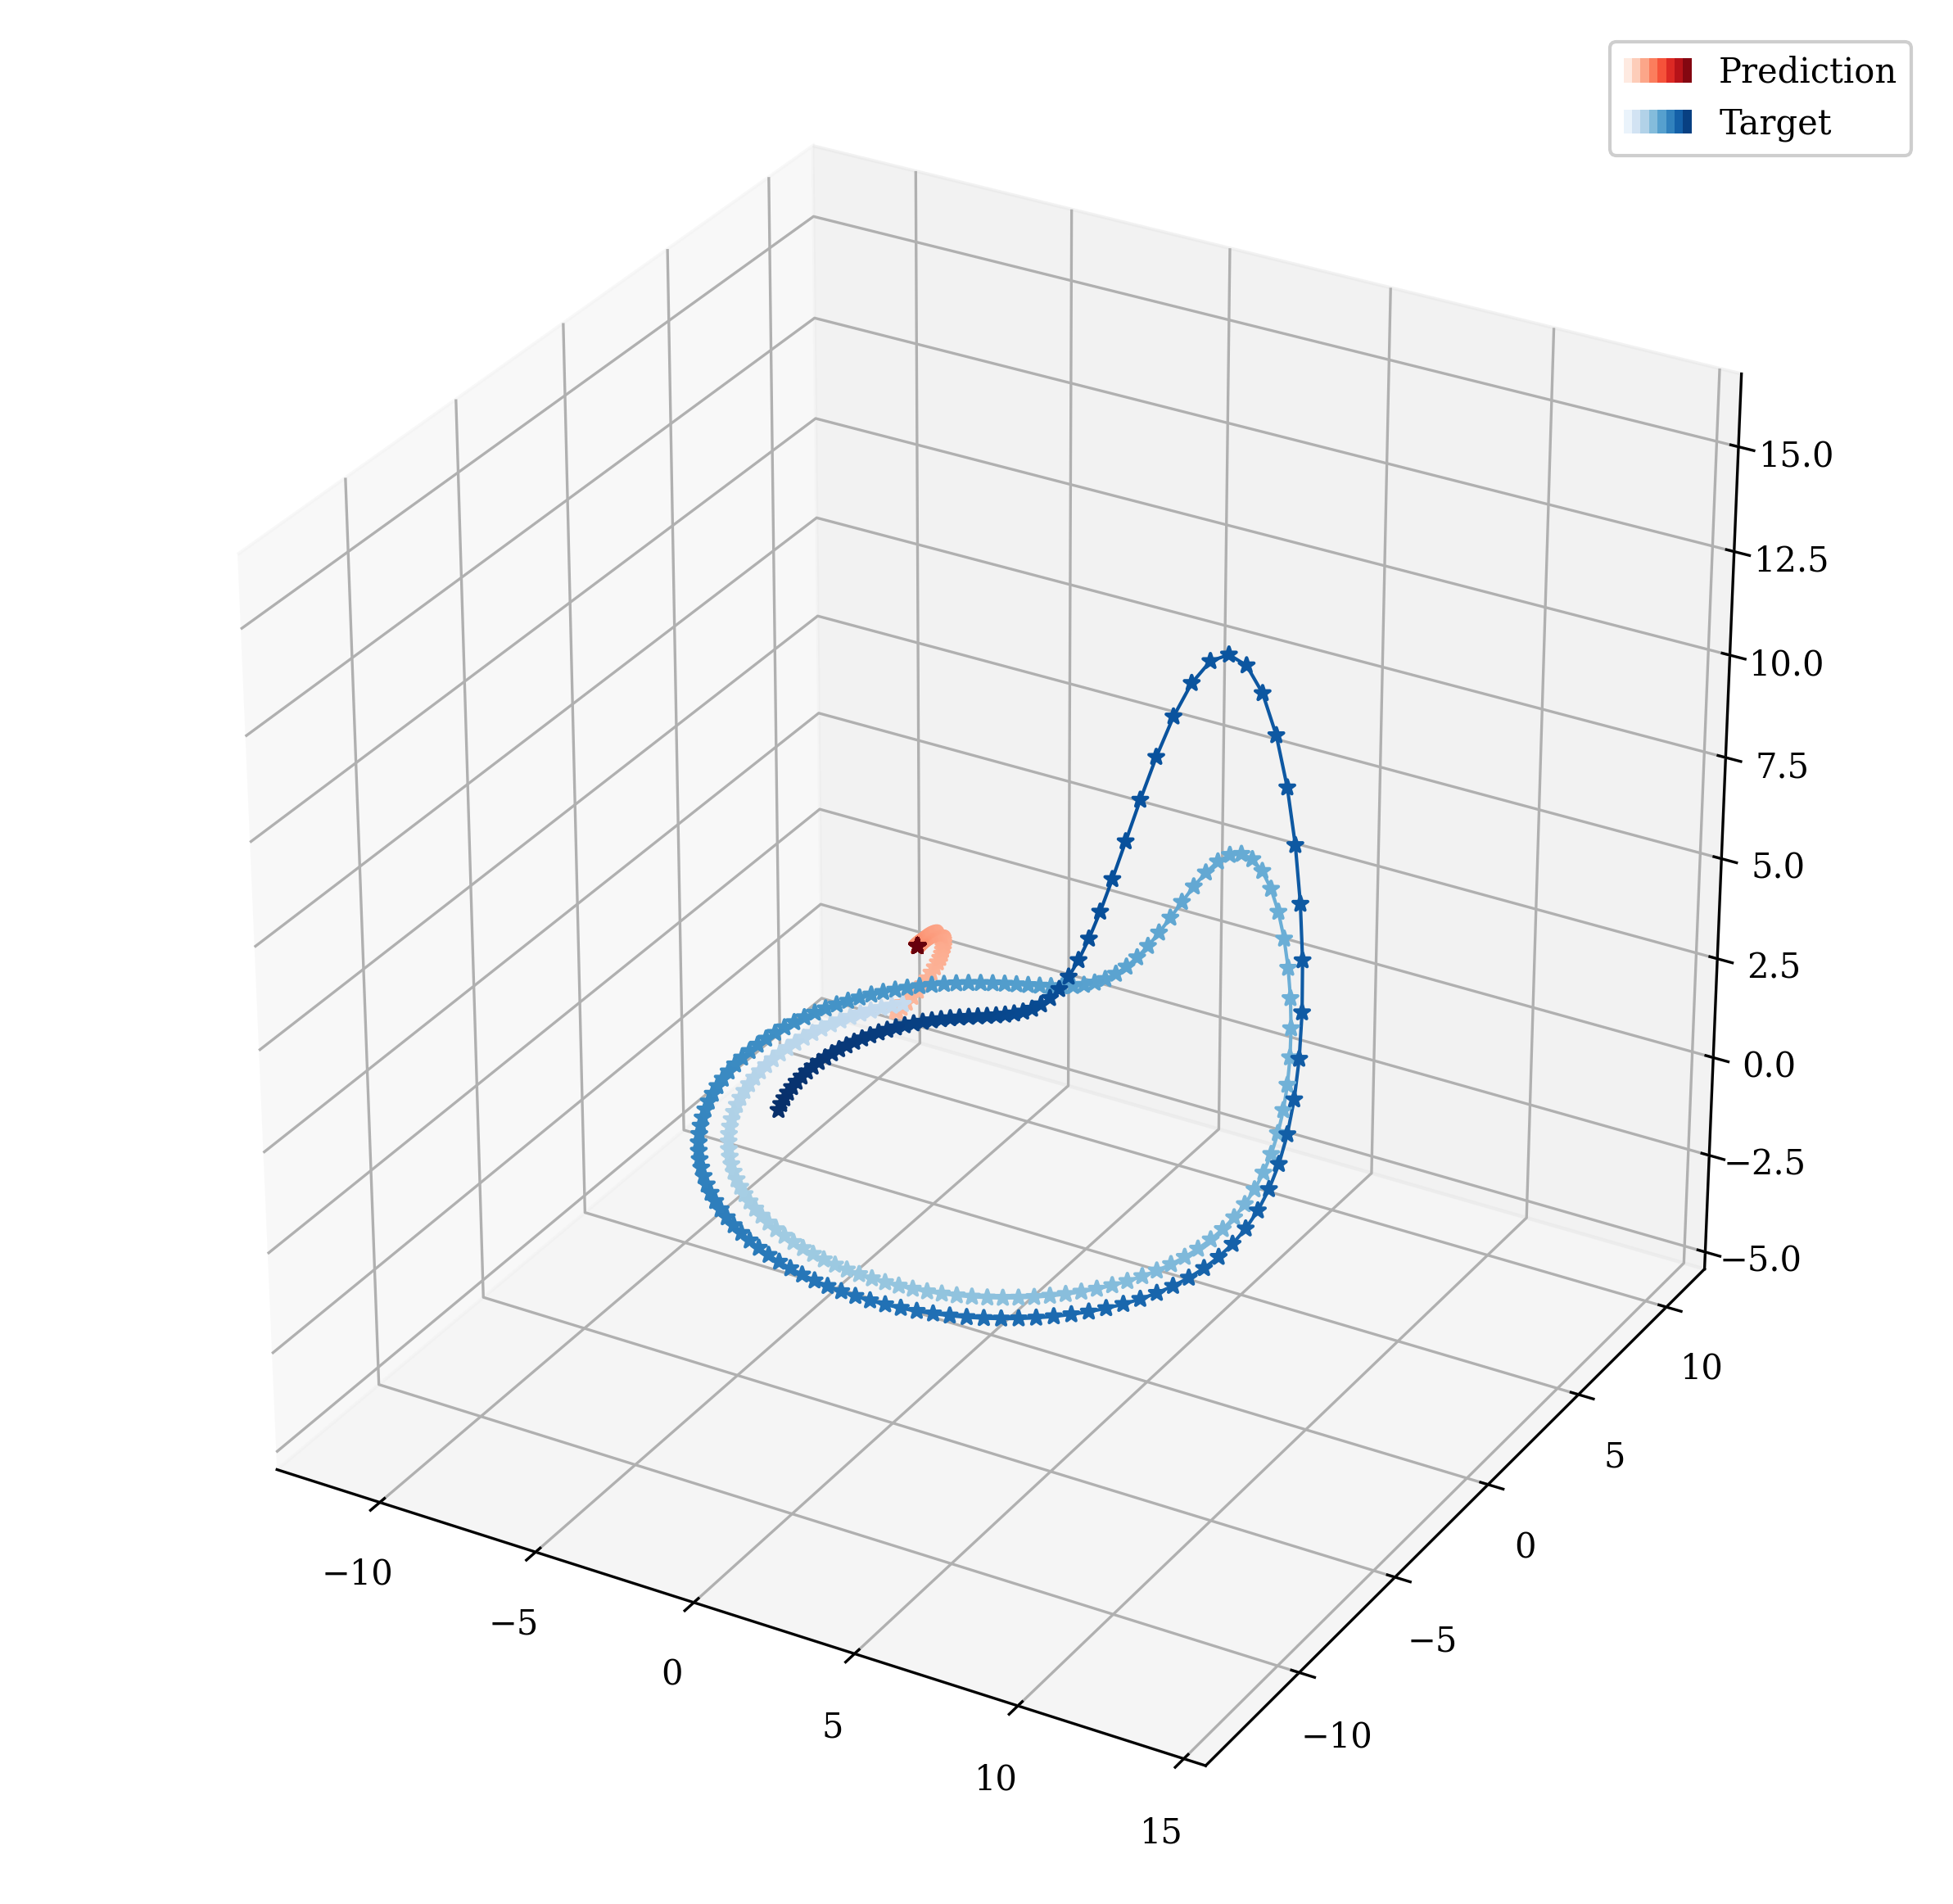

Validation prediction for epoch: 50


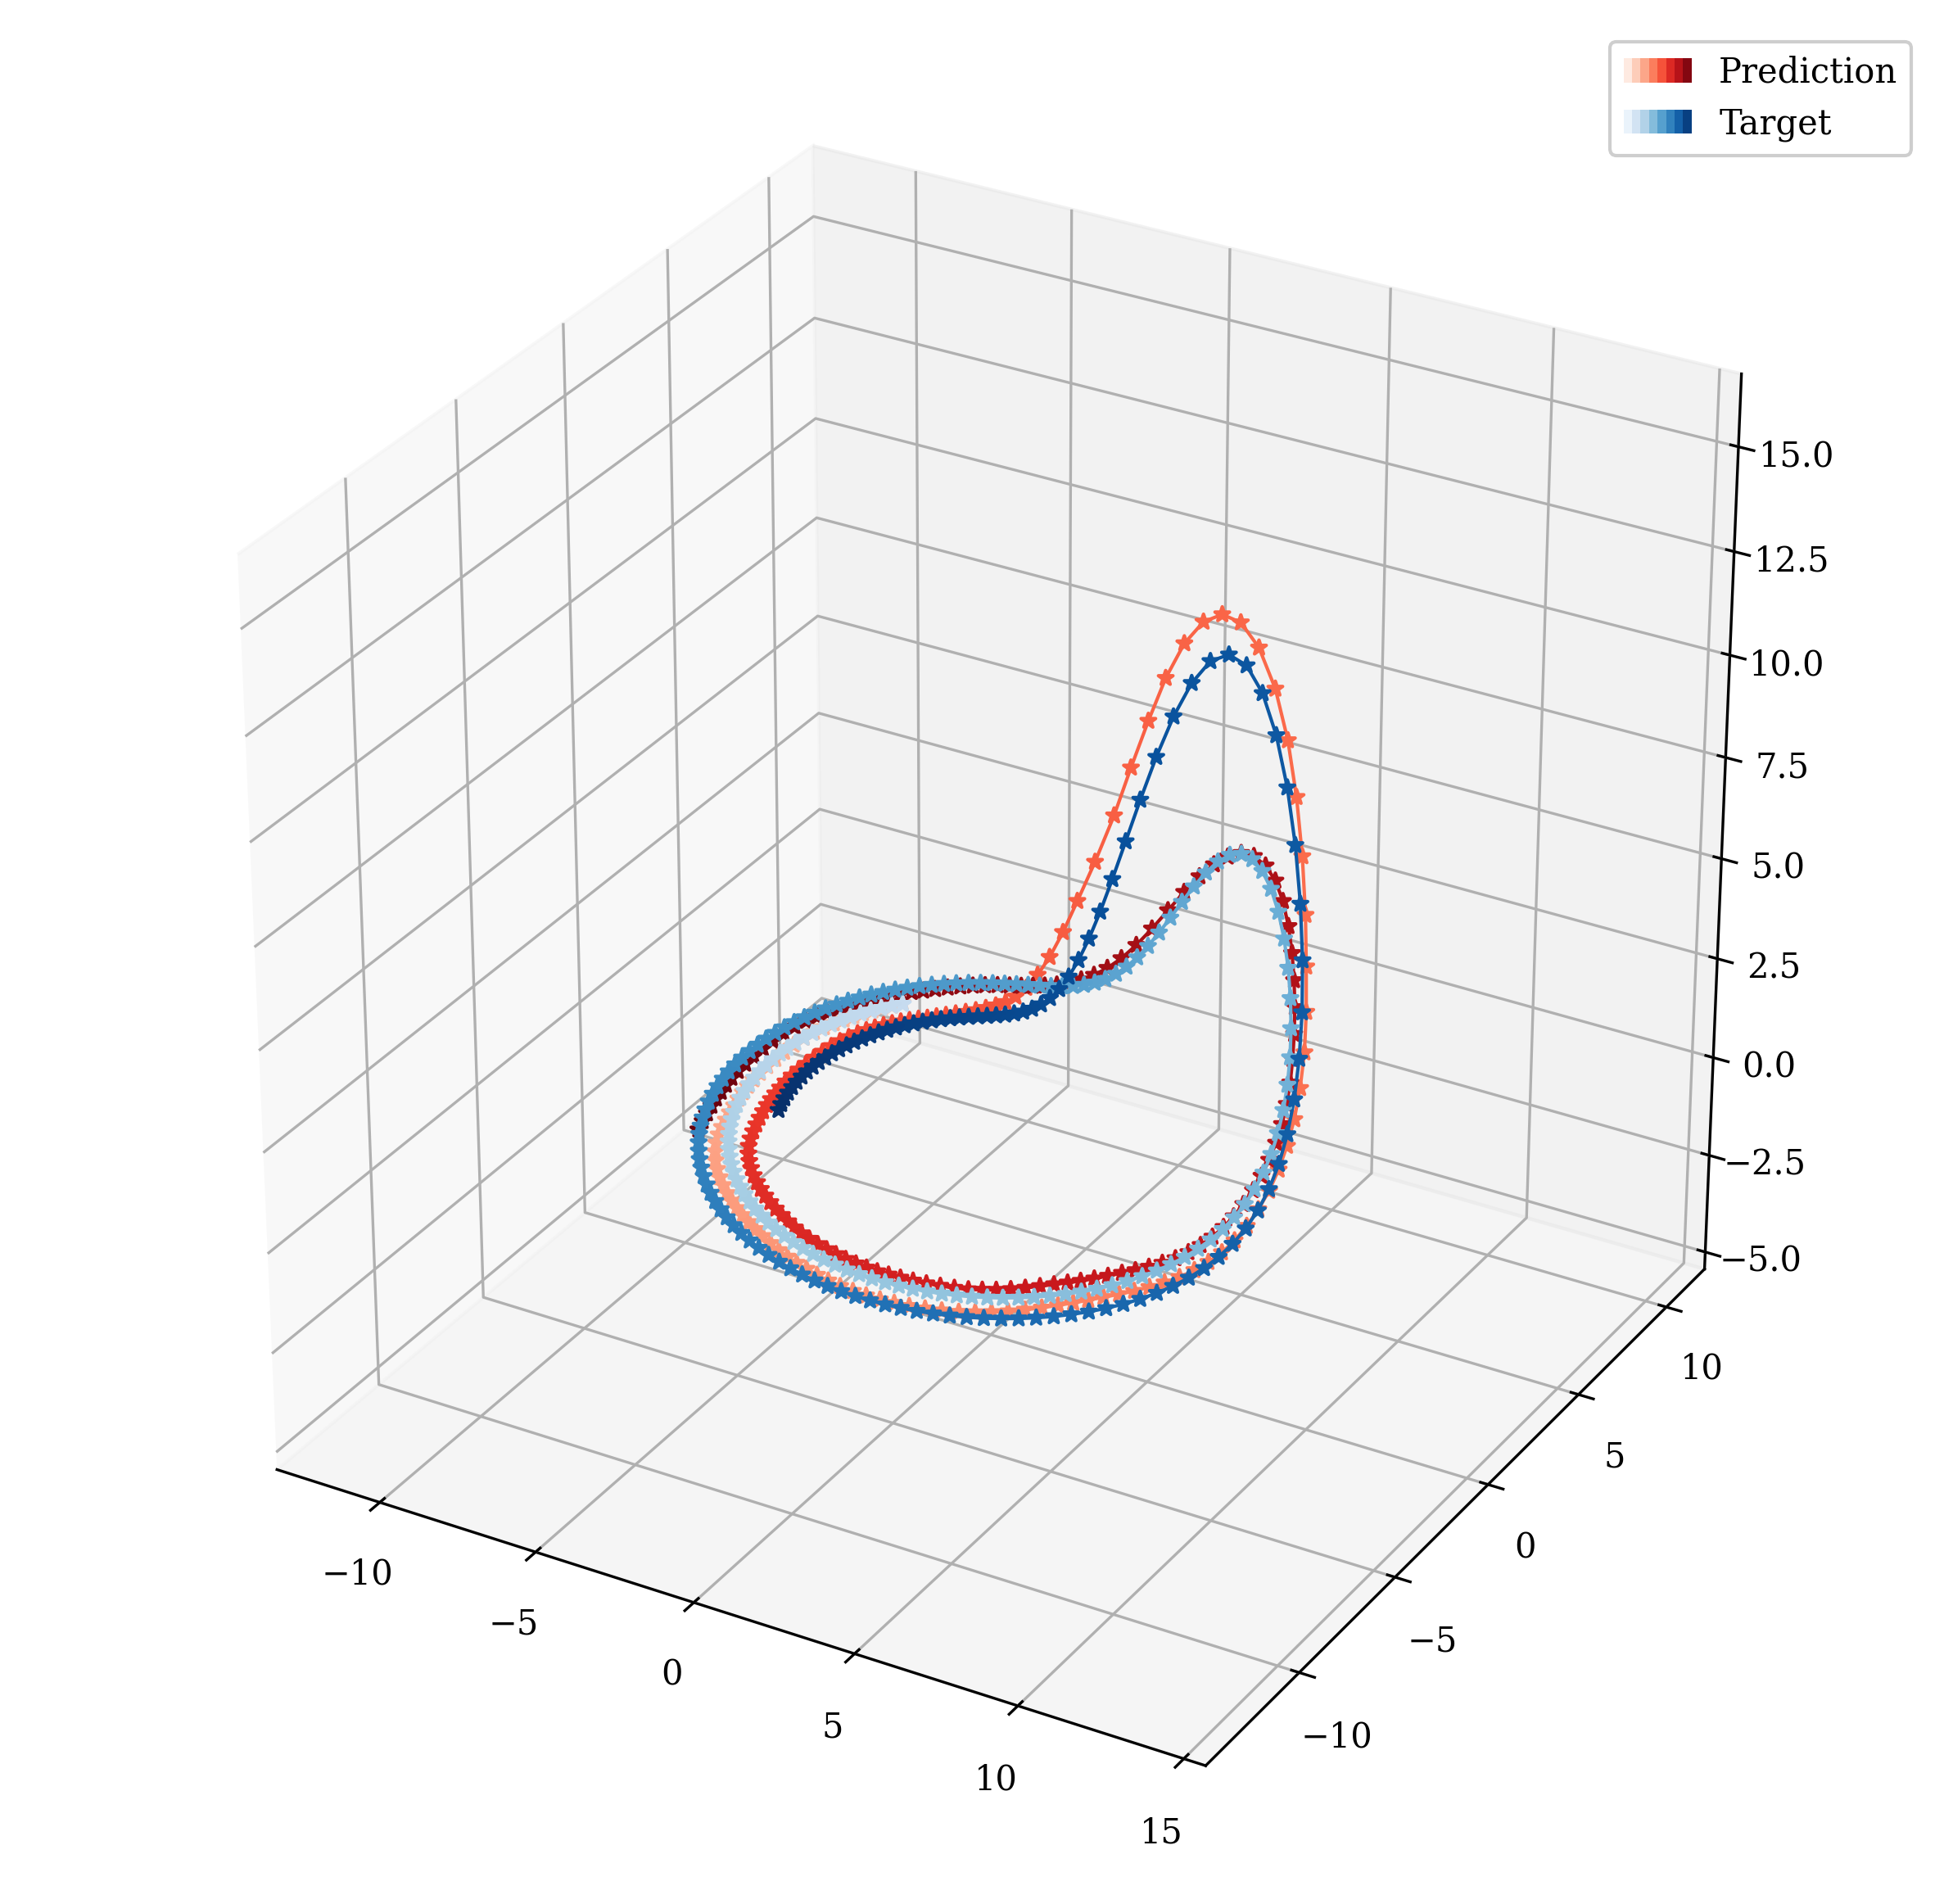

Validation prediction for epoch: 100


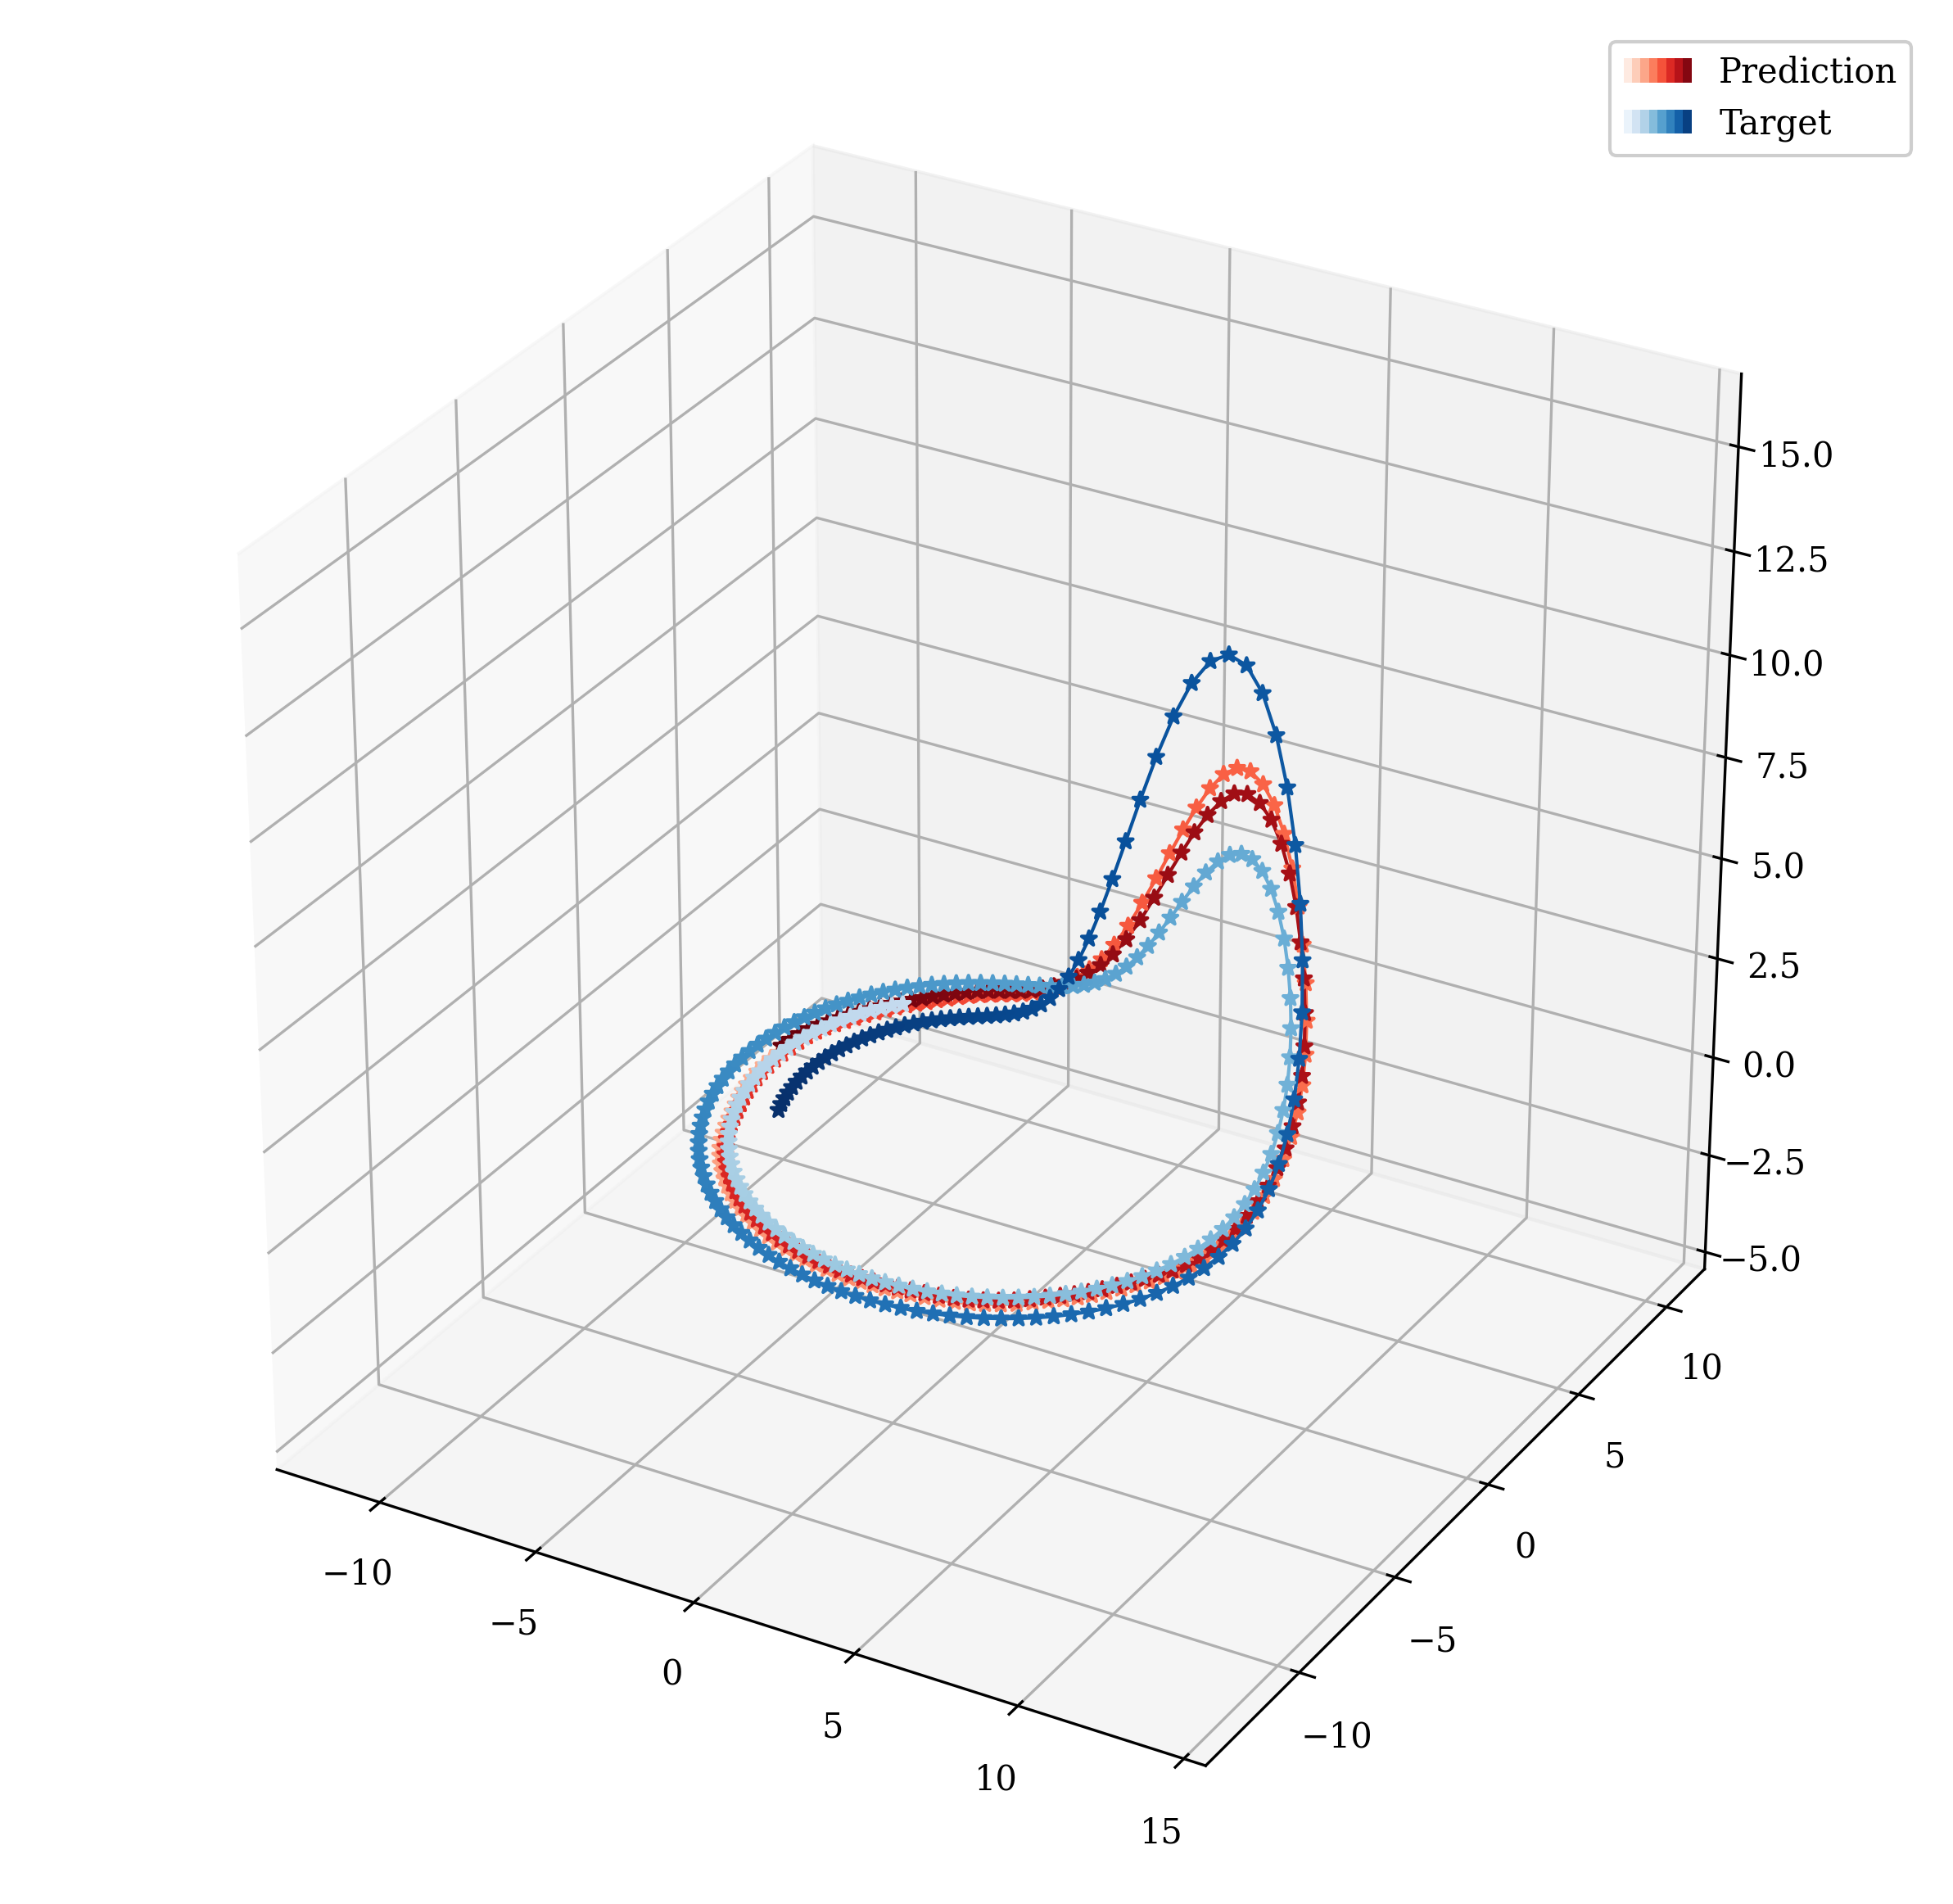

Validation prediction for epoch: 150


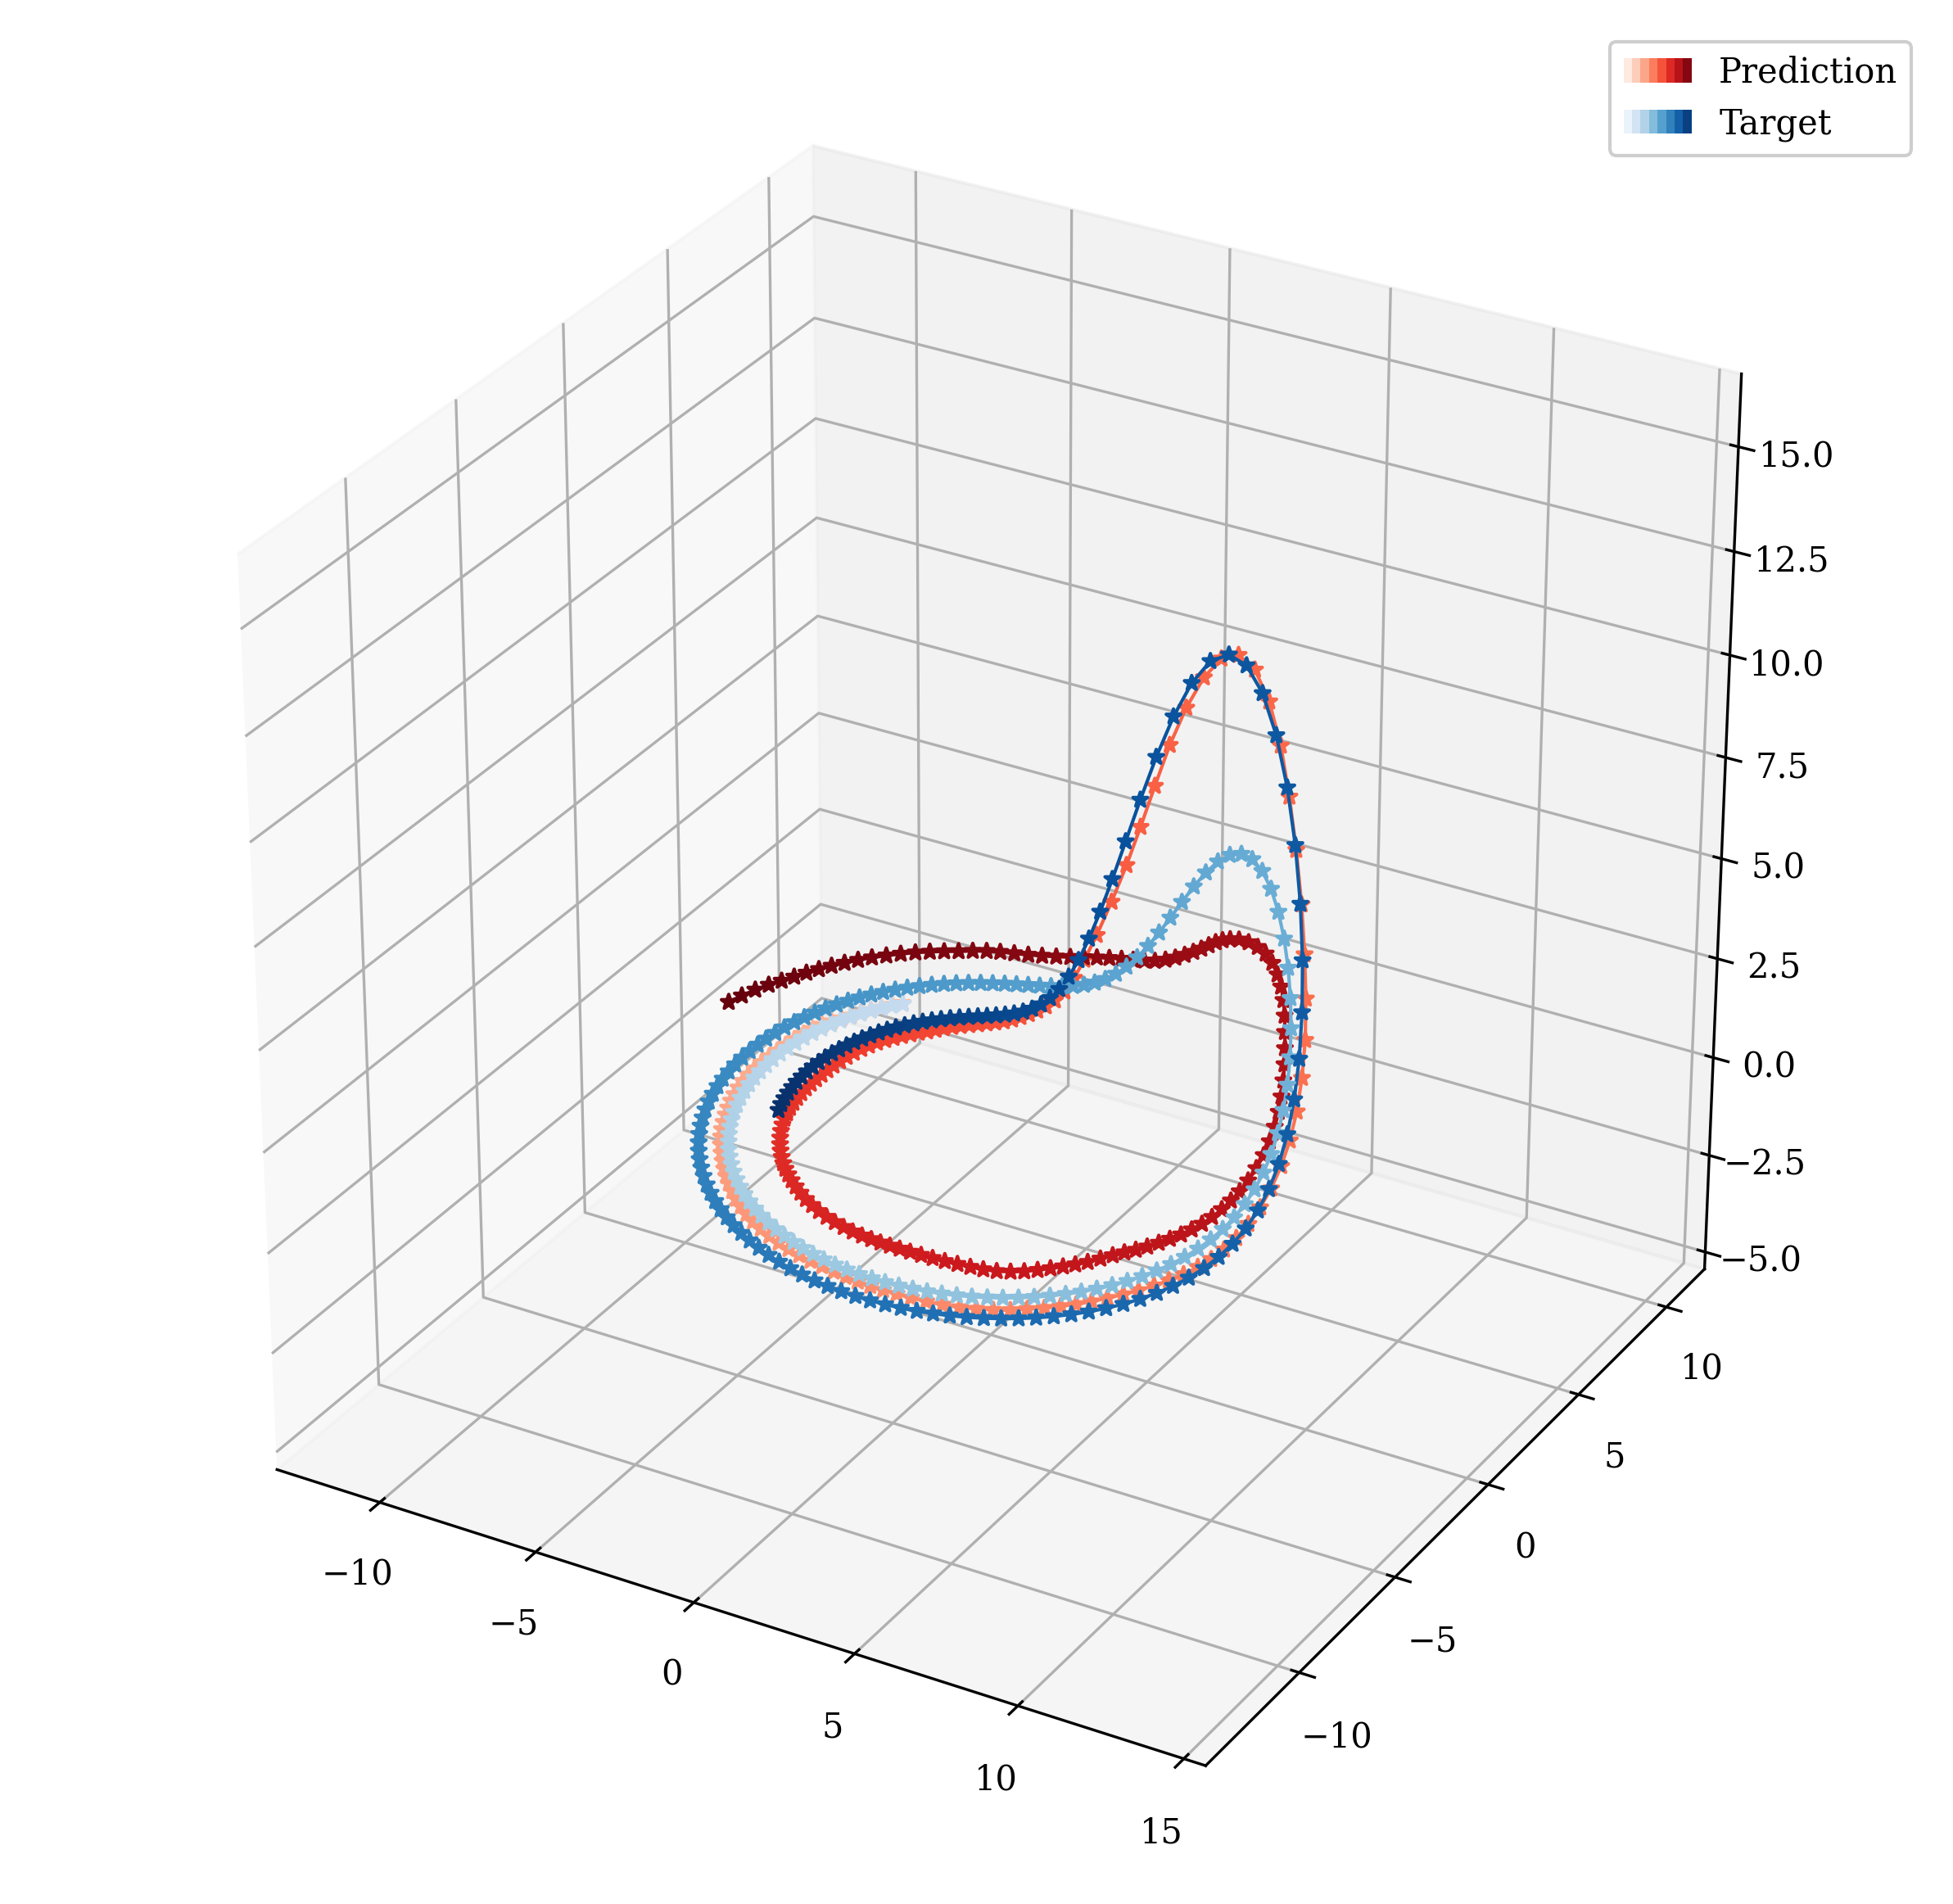

Validation prediction for epoch: 200


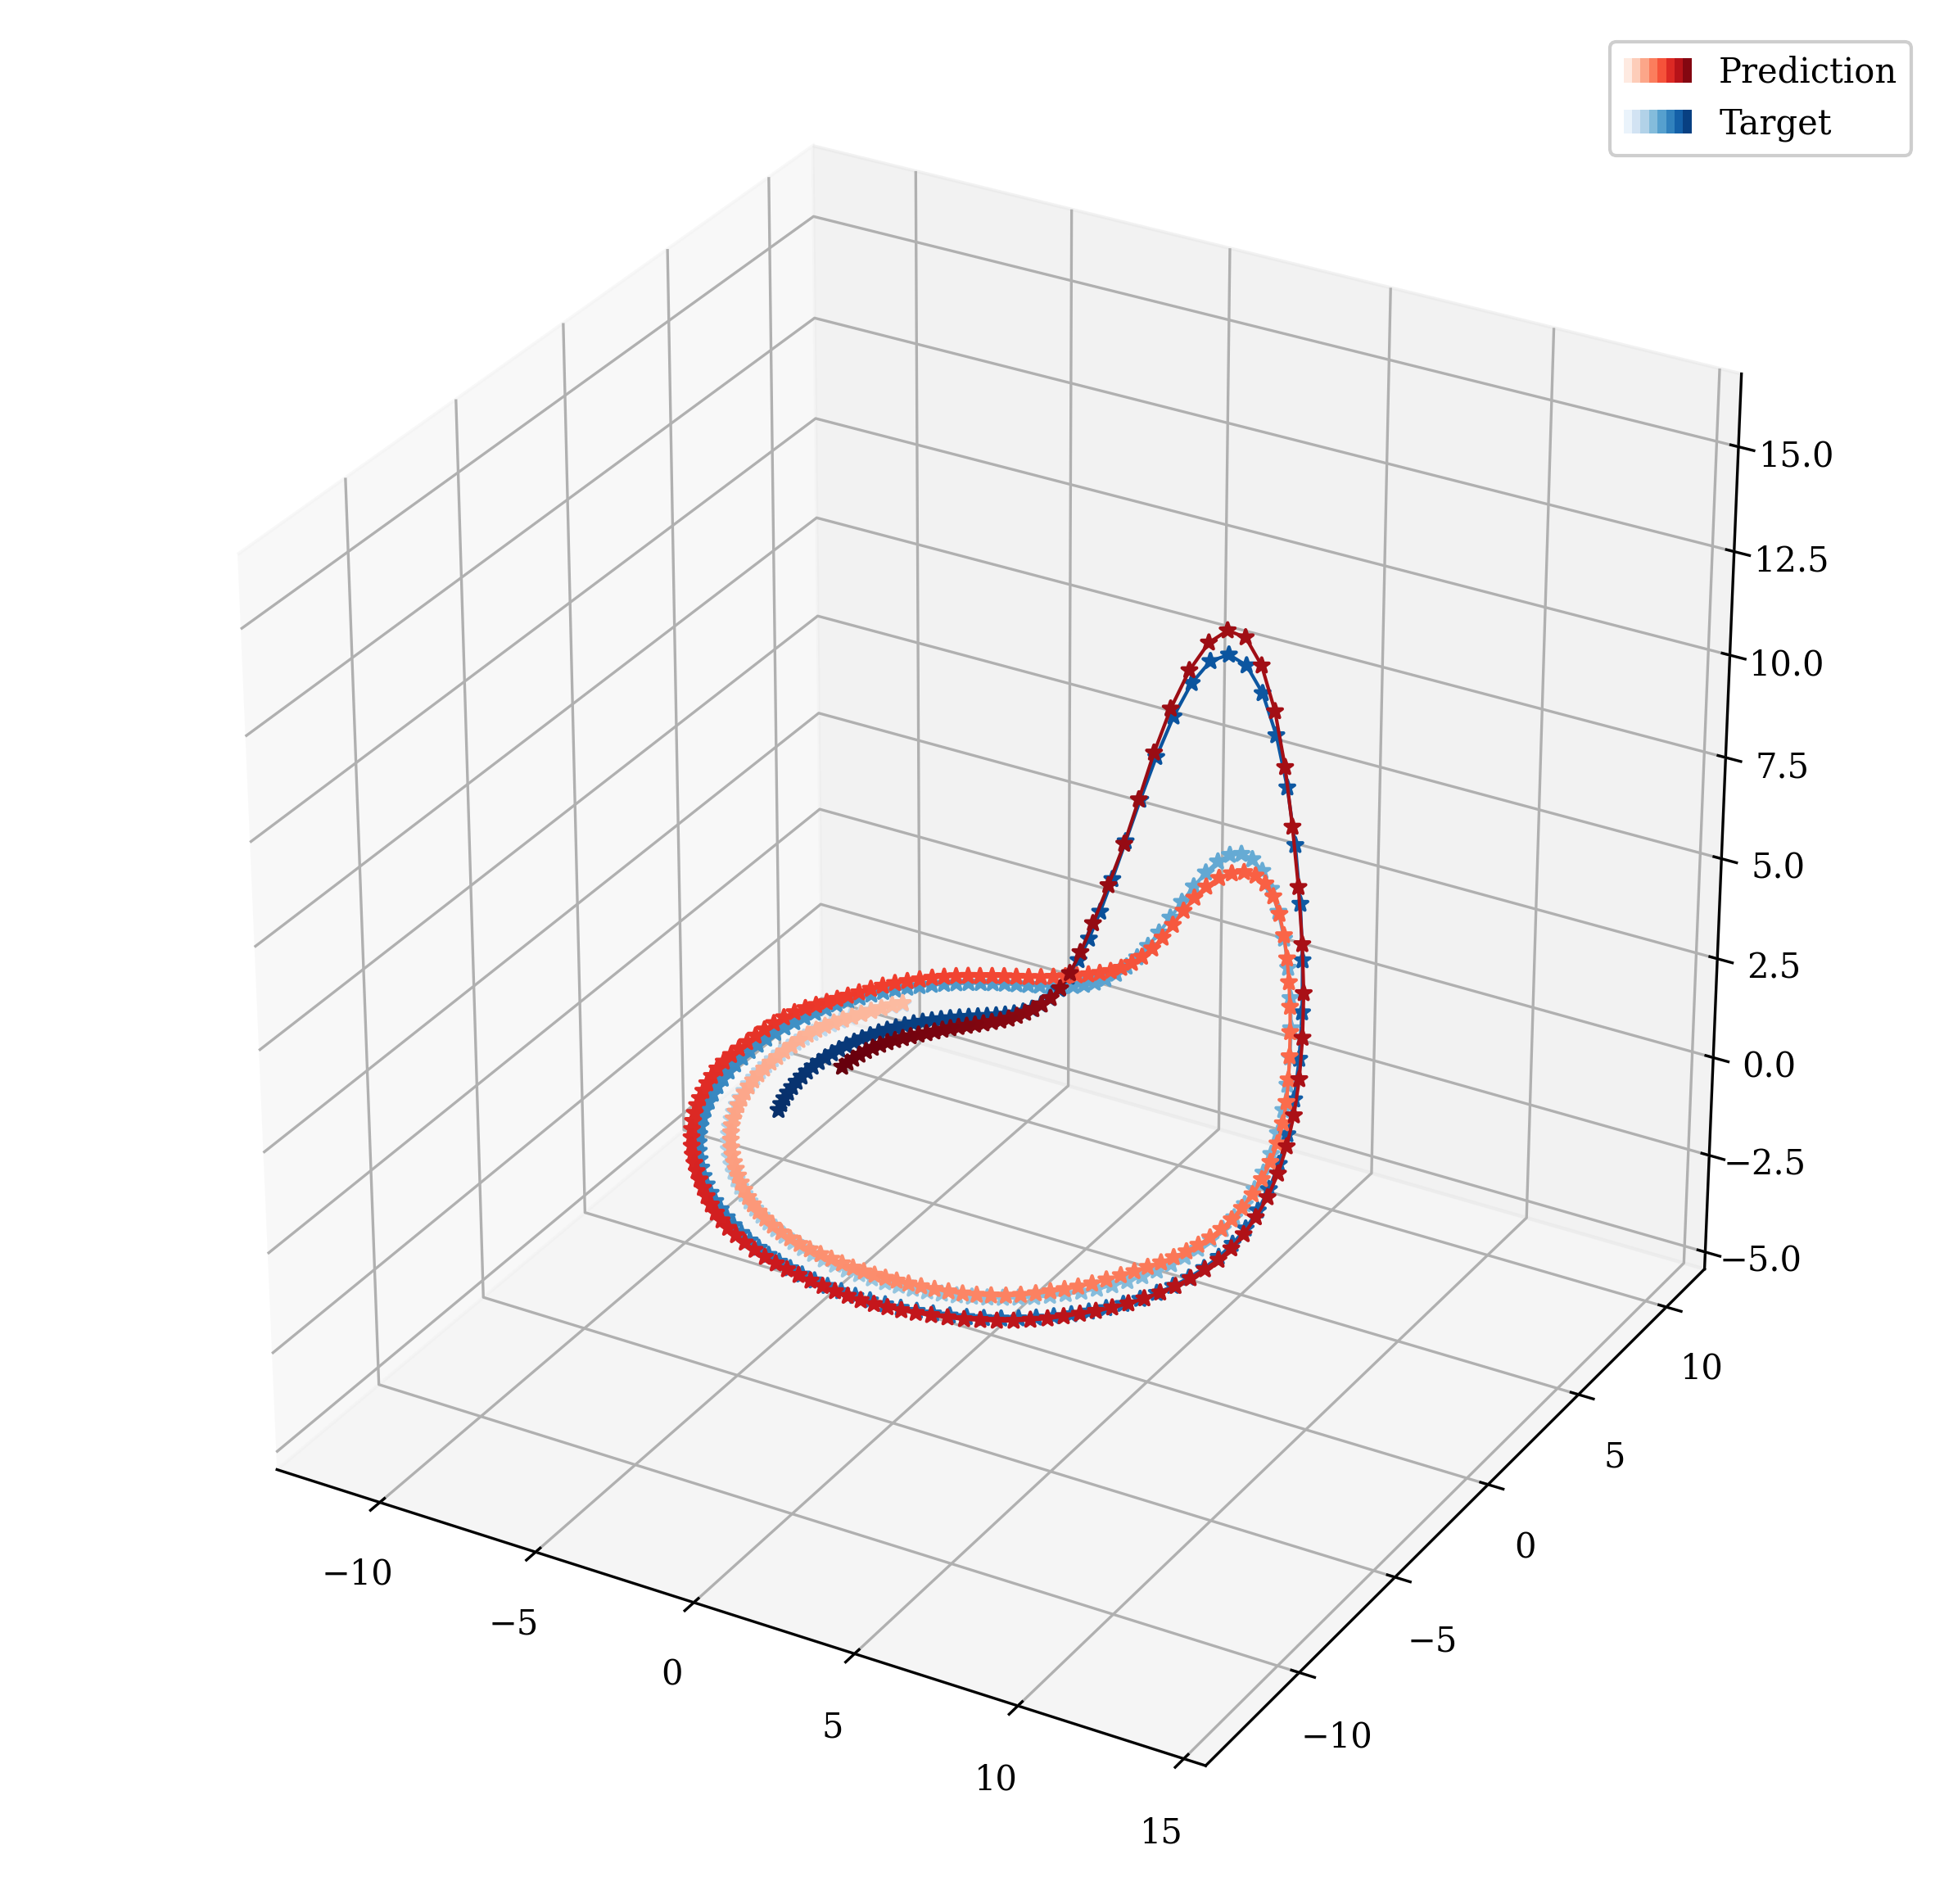

In [20]:
from IPython.display import Image, display

for epoch in [1, 50, 100, 150, 200]:
  print('Validation prediction for epoch: {:d}'.format(epoch))
  file_path = './outputs/rossler/ntrain2048_epochs200_batch32/viz/rosslerPred1_{:d}.png'.format(epoch)
  display(Image(file_path, width=300, height=300))